# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [1]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt

## Loading of the graph and calculation of some metrics

In [2]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [3]:
nodes

id              name  new_id
0     127397457601670               陳根德    1661
1     169014523134260               林淑芬      52
2     295363753921281       Chris White    3477
3     613631835423903  Stewart Hosie MP    3193
4     284882801581896   Frank Schäffler    4425
...               ...               ...     ...
5903  342943772496246       Kevin Byrne    3778
5904  193944157325672      Timur Husein     439
5905     142026376065     Jeremy Lefroy     159
5906  294019144024664   Ileana Argentin     107
5907     142338164826     Rafael Anchía     390

[5908 rows x 3 columns]

In [4]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [6]:
G.is_directed()

False

In [7]:
nkG = nk.nxadapter.nx2nk(G)

In [8]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [9]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [10]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [11]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [12]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

5.702505926176769

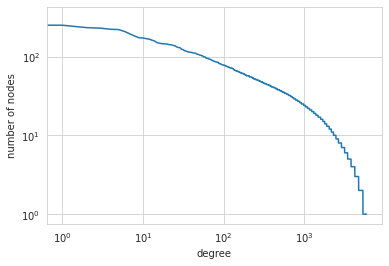

In [13]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [14]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.025147438049316406 [s]
solution properties:
-------------------  ----------
# communities         29
min community size     8
max community size   616
avg. community size  203.655
modularity             0.866943
-------------------  ----------


0.8669431710165385

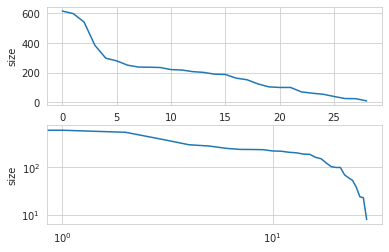

In [15]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [66]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(g,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [17]:
centrality("closeness","nx")

--- 42.04844880104065 seconds ---


{'Mark Bailey MP - Labor for Miller': 0.2479217398606096,
 'Jo-Ann Miller MP': 0.28501785886668596,
 'Senator Claire Moore': 0.24067658447116363,
 'Shane King MP-  Labor for Kurwongbah': 0.23458604798982996,
 'Di Farmer MP': 0.23739647825038193,
 'Leanne Linard MP': 0.2340282181357007,
 'Aaron Harper MP': 0.23984565393988627,
 'Sénateur Pierre-Hugues Boisvenu': 0.25438331969155215,
 'Jackie Trad': 0.2445033331953128,
 'Jim Madden - Labor for Ipswich West': 0.23985539623867744,
 '邱志偉': 0.23125122381045624,
 'Grace Grace MP': 0.23892373052801943,
 'Senator Chris Ketter': 0.24451345755693582,
 'Bill Shorten MP': 0.2734935852901672,
 'Craig Crawford - Labor For Barron River': 0.24564249760805357,
 'Stirling Hinchliffe MP': 0.24423029200099264,
 'Mark Ryan MP': 0.2536512027491409,
 'Dr Anthony Lynham': 0.2390785052026398,
 'Joe Kelly MP': 0.24162199762674413,
 'Linus Power': 0.24377657598150518,
 'Luke Howarth': 0.2566721724767452,
 'Andrew Leigh MP': 0.2450410822474894,
 'Don Brown MP': 0.

In [18]:
centrality("closeness","nk")

--- 0.5140469074249268 seconds ---


[(703, 0.3588574901245822),
 (853, 0.3235084643620227),
 (941, 0.32047107348312165),
 (855, 0.3174219211955061),
 (228, 0.3124669277172188),
 (157, 0.31085491682459465),
 (50, 0.3096973829128861),
 (219, 0.3075360658299047),
 (810, 0.30554693159474283),
 (233, 0.3051521885173893),
 (177, 0.30491583187028815),
 (857, 0.30389583654984303),
 (147, 0.30261876697586226),
 (209, 0.3008763884642821),
 (424, 0.29979184647408236),
 (948, 0.2995637175324676),
 (1392, 0.2960641764853347),
 (2910, 0.29591581057379107),
 (2527, 0.2958120428814748),
 (2123, 0.29579722486600213),
 (34, 0.29533860158047415),
 (255, 0.29471950489119586),
 (214, 0.2946459757497131),
 (57, 0.2932849905632264),
 (2495, 0.2932412971147639),
 (799, 0.29271798939176125),
 (692, 0.2926889714993804),
 (308, 0.29238463061992476),
 (213, 0.28997250049106266),
 (943, 0.28957434287956063),
 (1887, 0.28936149360513547),
 (230, 0.2890357317670093),
 (1576, 0.2890215848465567),
 (138, 0.28893673239712286),
 (247, 0.28878129890453835)

In [19]:
centrality("betweenness","nx")

--- 180.58680176734924 seconds ---


{'Mark Bailey MP - Labor for Miller': 0.00015704690880821877,
 'Jo-Ann Miller MP': 0.003622567572049236,
 'Senator Claire Moore': 3.0391491689467818e-05,
 'Shane King MP-  Labor for Kurwongbah': 7.558013769192619e-06,
 'Di Farmer MP': 1.3217045674452099e-05,
 'Leanne Linard MP': 2.8304325209334307e-05,
 'Aaron Harper MP': 3.6119407945364613e-05,
 'Sénateur Pierre-Hugues Boisvenu': 0.0034715850285264626,
 'Jackie Trad': 0.0002315851911273831,
 'Jim Madden - Labor for Ipswich West': 1.3753381654531965e-05,
 '邱志偉': 0.0009267561274619335,
 'Grace Grace MP': 2.0367504293817236e-05,
 'Senator Chris Ketter': 0.00029847026197884975,
 'Bill Shorten MP': 0.009342744840905156,
 'Craig Crawford - Labor For Barron River': 0.00011441971646975493,
 'Stirling Hinchliffe MP': 0.00013155311713819763,
 'Mark Ryan MP': 0.0017369151141793386,
 'Dr Anthony Lynham': 2.8117955370540076e-05,
 'Joe Kelly MP': 4.7822553272661366e-05,
 'Linus Power': 0.0001292649442780126,
 'Luke Howarth': 0.0002881606999433047,


In [20]:
centrality("betweenness","nk")

--- 4.619611024856567 seconds ---


[(703, 0.5366164402734528),
 (177, 0.111041964907807),
 (157, 0.10829224089393592),
 (810, 0.09654886256228755),
 (255, 0.09017589220675055),
 (140, 0.07455223950912733),
 (50, 0.0707360034313389),
 (951, 0.0681602659432724),
 (138, 0.06358624632468851),
 (638, 0.05798552776765502),
 (308, 0.05758472422797189),
 (853, 0.0555913327231992),
 (209, 0.046998406061421916),
 (2495, 0.04551044945392929),
 (202, 0.04419349057743662),
 (767, 0.04380878402193166),
 (228, 0.04346008515930888),
 (2910, 0.040075474483230684),
 (855, 0.04004459839665027),
 (1027, 0.03930983974933032),
 (941, 0.038083170178616815),
 (147, 0.0378214929569395),
 (1229, 0.03777859538763543),
 (1265, 0.03668379124514485),
 (1392, 0.03665625937969772),
 (243, 0.034449874113980844),
 (34, 0.03324997301123422),
 (857, 0.032531214358767234),
 (1231, 0.03140014966292291),
 (2123, 0.030463706190246985),
 (3723, 0.029623480315722064),
 (708, 0.029332385231254837),
 (219, 0.0293289444039085),
 (1397, 0.028578412735030912),
 (233

In [21]:
centrality("approxclose","nk")

--- 0.010541200637817383 seconds ---


[(262, 0.00016934801016088062),
 (263, 0.00016934801016088062),
 (177, 8.467400508044031e-05),
 (261, 8.467400508044031e-05),
 (264, 8.467400508044031e-05),
 (308, 8.467400508044031e-05),
 (578, 8.467400508044031e-05),
 (579, 8.467400508044031e-05),
 (580, 8.467400508044031e-05),
 (581, 8.467400508044031e-05),
 (584, 8.467400508044031e-05),
 (585, 8.467400508044031e-05),
 (589, 8.467400508044031e-05),
 (592, 8.467400508044031e-05),
 (897, 8.467400508044031e-05),
 (981, 8.467400508044031e-05),
 (1027, 8.467400508044031e-05),
 (1859, 8.467400508044031e-05),
 (1860, 8.467400508044031e-05),
 (1861, 8.467400508044031e-05),
 (1879, 8.467400508044031e-05),
 (1880, 8.467400508044031e-05),
 (1918, 8.467400508044031e-05),
 (2448, 8.467400508044031e-05),
 (2666, 8.467400508044031e-05),
 (2967, 8.467400508044031e-05),
 (3053, 8.467400508044031e-05),
 (3057, 8.467400508044031e-05),
 (3058, 8.467400508044031e-05),
 (3060, 8.467400508044031e-05),
 (3066, 8.467400508044031e-05),
 (3070, 8.467400508044

In [22]:
centrality("approxbet","nk")

--- 24.02125644683838 seconds ---


[(703, 0.26734313806043897),
 (177, 0.0563087119656006),
 (157, 0.05393969271218404),
 (810, 0.04838002903075559),
 (255, 0.045901459754059654),
 (140, 0.03828773313614286),
 (50, 0.0351244762139508),
 (951, 0.03431654479226539),
 (138, 0.03227617560868697),
 (638, 0.029112918686494918),
 (853, 0.028072193465340824),
 (308, 0.02792156218333168),
 (209, 0.022882261112480276),
 (2495, 0.022827486100840583),
 (202, 0.02237559225481315),
 (228, 0.02112946074001022),
 (767, 0.02100621696382092),
 (855, 0.02023936680086527),
 (2910, 0.020020266754306515),
 (1027, 0.019198641579711177),
 (1229, 0.019075397803521875),
 (941, 0.018993235286062345),
 (1392, 0.018555035192944828),
 (147, 0.01841809766384561),
 (1265, 0.01826746638183646),
 (34, 0.01704872237285338),
 (857, 0.01670637855010532),
 (243, 0.016637909785555707),
 (1231, 0.01563826582313138),
 (708, 0.015610878317311536),
 (2123, 0.015063128200914645),
 (3723, 0.014994659436365031),
 (219, 0.014761865636896354),
 (1397, 0.0142825842850

In [23]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [24]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.42877616607313473

In [25]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [26]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [27]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [28]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [29]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3489587


In [30]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 897258


In [31]:
#Chung-Lu model
degreeSequence = [CRG.degree(v) for v in CRG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
#nk.community.detectCommunities(CLG)

5906 897584


In [77]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [158]:
# Generate random graphs
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G
#    alfa: float

def pvalues(FG,alfa):
    plarger = sum(map(lambda x : x>= alfa, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= alfa, FG))/len(FG)
    return plarger,psmaller

In [91]:
ER_graphs = generateRandGraphs("ER", 100, [G.number_of_nodes(), 0.005])

In [88]:
ER_graphs[0].numberOfEdges(),ER_graphs[0].numberOfNodes(),ER_graphs[0].numberOfSelfLoops()

(87069, 5906, 0)

In [85]:
nkG.numberOfEdges(),nkG.numberOfNodes(),nkG.numberOfSelfLoops()

(41702, 5906, 0)

In [92]:
banana = list(map(nk.centrality.Closeness,ER_graphs,[True for i in range(100)],[False for i in range(100)]))

In [93]:
closeness_list = list(tqdm(map(lambda obj: obj.run(), banana)))

100it [01:06,  1.49it/s]


In [97]:
closeness_list_ranking = list(map(lambda obj: obj.ranking(), closeness_list))
closeness_list_ranking

[[(4804, 0.36342934515017233),
  (5830, 0.36149372513008876),
  (4473, 0.3610075197163294),
  (2617, 0.3609413202933985),
  (207, 0.3608530921535077),
  (2887, 0.36074286761561486),
  (1679, 0.360236700829673),
  (873, 0.36012685247301335),
  (138, 0.36001707108889164),
  (1271, 0.35981963317287186),
  (2639, 0.35981963317287186),
  (4879, 0.35981963317287186),
  (5268, 0.35977578748552974),
  (3198, 0.35962241169305725),
  (3418, 0.3595786140543174),
  (4327, 0.3595348270823186),
  (4229, 0.35946916661593714),
  (750, 0.3594472851229608),
  (3559, 0.35938165662467286),
  (299, 0.3592941892303012),
  (4171, 0.3591412236954142),
  (2810, 0.3590975431768426),
  (5824, 0.3590975431768426),
  (2325, 0.3590320423177479),
  (5136, 0.3590320423177479),
  (1764, 0.3589665653495441),
  (658, 0.3589011122591625),
  (732, 0.3589011122591625),
  (4164, 0.3589011122591625),
  (2703, 0.35883568303354396),
  (2852, 0.35883568303354396),
  (283, 0.3588138785926961),
  (5666, 0.3587484811664642),
  (16

In [180]:
import itertools
import seaborn as sns
closeness_list_ranking_merged = list(itertools.chain(*closeness_list_ranking))
closeness_list_ranking_merged = pd.DataFrame(closeness_list_ranking_merged)
closeness_list_ranking_merged.columns = {"key","closeness"}
mean_by_key = closeness_list_ranking_merged.groupby("key").mean()
std_by_key = closeness_list_ranking_merged.groupby("key").std()
f = pd.DataFrame(centrality(nkG,"closeness","nk"))
f.columns = {"key","closeness"}
f = f.set_index('key').sort_index()
zscore_closeness = zscore(f,mean_by_key,std_by_key)
zscore_closeness.columns = {"zscore"}
zscore_closeness["centrality_f"] = f
zscore_closeness["mean_rand"] = mean_by_key
zscore_closeness["std_rand"] = std_by_key
sns.violinplot(x=zscore_closeness["centrality_f"], y=zscore_closeness["zscore"],palette="Set3", bw=.2, cut=1, linewidth=1)

--- 0.47718024253845215 seconds ---


<AxesSubplot:xlabel='centrality_f', ylabel='zscore'>

Error in callback <function flush_figures at 0x7f94dc2f8ca0> (for post_execute):


KeyboardInterrupt: 

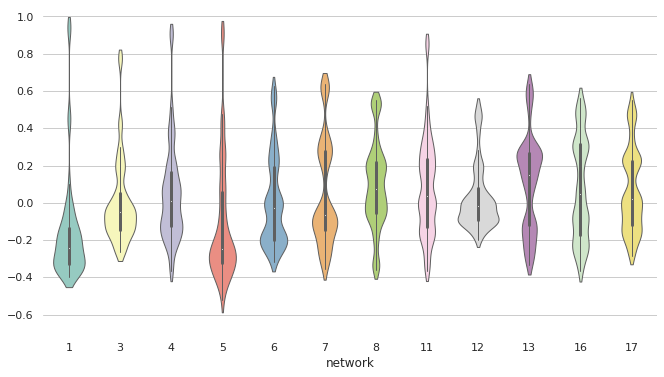

In [178]:



import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Load the example dataset of brain network correlations
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Pull out a specific subset of networks
used_networks = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Compute the correlation matrix and average over networks
corr_df = df.corr().groupby(level="network").mean()
corr_df.index = corr_df.index.astype(int)
corr_df = corr_df.sort_index().T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=corr_df, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)


In [35]:
avg_CC_randG = list(map(nk.globals.clustering, ER_graphs))
zscore_randG = zscore(ACC_nkG,np.mean(avg_CC_randG), np.std(avg_CC_randG))
print(zscore_randG)

0.42877616607313473 0.20020715712672632 0.0026745488898141027
85.46077053102414


In [36]:
pvalues_ = pvalues(avg_CC_randG, 0.1 )
pvalues_

(1.0, 0.0)

In [37]:
avg_CC_randG

[0.2015981933466516,
 0.1990358724919656,
 0.19981759749848,
 0.20099018500825155,
 0.1972118474767654,
 0.20151133501259447,
 0.19512724745939372,
 0.20689655172413793,
 0.20042560583688004,
 0.19786328498219405,
 0.20042560583688004,
 0.20211934335099452,
 0.2027273516893946,
 0.19799357248327978,
 0.19873186832276557,
 0.19973073916442283,
 0.20446451837053764,
 0.2001650308347086,
 0.19569182663076523,
 0.20099018500825155,
 0.2004690350039086,
 0.1997741683314514,
 0.20168505168070877,
 0.20350907669590898,
 0.1999478849995657,
 0.20164162251368017,
 0.20303135585859464,
 0.20828628506905236,
 0.19929644749413705,
 0.202379918353166,
 0.20537653087813776,
 0.20077303917310865,
 0.19790671414922262,
 0.19786328498219405,
 0.2042039433683662,
 0.19716841830973683,
 0.2009033266741944,
 0.19764613914705115,
 0.19955702249630852,
 0.20190219751585164,
 0.20064275167202292,
 0.20246677668722313,
 0.19742899331190827,
 0.19855815165465127,
 0.19925301832710848,
 0.20025188916876574,
 0.